# Model evaluation

In [1]:
%load_ext watermark

In [16]:
import pymc as pm
import pandas as pd
import itertools as itt
import arviz as az
from pathlib import Path
from collections import defaultdict
import altair as alt
import numpy as np
import pickle

import sys
sys.path.append("../")

from models import OneAdvantage
from models import TeamSpecificAdvantage

STORAGE_PATH = '../storage/'
VIZ_PATH = '../vis/'

%watermark --iversions

altair: 4.2.0
pandas: 1.4.2
arviz : 0.12.0
numpy : 1.22.3
sys   : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
pymc  : 4.0.0b6



## Collect the models available

In [3]:
def create_model_dict(p):
    
    filename = p.stem
    mu_prior, var_prior, model_type = filename.split("-")
    mu_prior = "Empirical" if mu_prior == "sokol" else "Flat"
    folder = p.parent.stem
    strength_prior = "Flat" if "non-informative" in folder else "Empirical"
    period = folder.strip("non-informative")
    unique_name = folder + "-" + filename
    
    return {
        "advantage-prior" : mu_prior,
        "advantage-variance": var_prior,
        "model-type" : model_type,
        "strength-prior": strength_prior,
        "subsample": period,
        "trace-path": p.absolute(),
        "data-path": p.parent.joinpath("data.pickle"),        
        "name": unique_name
    }    
    
models = [create_model_dict(p) for p in Path(STORAGE_PATH).glob("*/*.netcdf")]

## Load the traces, compare models based on deviance

In [4]:
#load the traces
for model in models:
    model['trace'] = az.from_netcdf(model['trace-path'])

In [5]:
#split based subsample (need to be the same amount of observations)
by_subsample = defaultdict(list)
for model in models:
    by_subsample[model['subsample']].append(model)

## Compare based on deviance

In [ ]:
res = []
for period, mods in by_subsample.items():    
    dict_of_models = {m['name'] : m['trace'] for m in mods}
    res.append(az.compare(dict_of_models, scale='deviance'))

In [75]:
all_results = pd.concat(res)

In [77]:
model_properties = pd.DataFrame(models).drop(['trace-path', 'data-path', 'trace'], axis=1).set_index('name')
deviances = pd.merge(all_results, model_properties, left_index=True, right_index=True)

In [124]:
c1 = alt.Chart(deviances[deviances['subsample'] == '5-seasons']).mark_point().encode(
    x = alt.X("model-type", title = "Model type"),
    y = alt.Y("loo", title = "Deviance", scale=alt.Scale(domain=(16_425, 16_455))),
    color = alt.Color("advantage-prior", title="Home advantage prior"),
    shape = alt.Shape("strength-prior", title="Pair-wise strength prior"),
    fill = alt.Fill("advantage-variance", title="Home advantage variance prior")
).properties(width=300, title="10-seasons")

c2 = alt.Chart(deviances[deviances['subsample'] != '5-seasons']).mark_point().encode(
    x = alt.X("model-type", title = "Model type"),
    y = alt.Y("loo", title = "Deviance", scale=alt.Scale(domain=(1_856, 1_869))),
    color = alt.Color("advantage-prior", title="Home advantage prior"),
    shape = alt.Shape("strength-prior", title="Pair-wise strength prior"),
    fill = alt.Fill("advantage-variance", title="Home advantage variance prior")
).properties(width=300, title="2020 season")

c1 | c2

alt.HConcatChart(...)

In [6]:
best_names = ['5-seasons-non-informative-flat-hyper-team', '2020-informative-flat-simple-single']
best_models = dict([(m['subsample'], m) for m in models if m['name'] in best_names])

## Model diagnostics

In [ ]:
for name, model in best_models.items():
    axes = az.plot_trace(model['trace'], figsize=(20,50), show=False)
    fig = axes.ravel()[0].figure
    fig.savefig(VIZ_PATH + name + '-trace.png')

## Compare key coefficients

In [125]:
#generate summaries 
for model in models:
    model['summary'] = az.summary(model['trace'], hdi_prob=0.9)

In [153]:
results = []
for model in models:
    df = model['summary'].loc[["cup_impact[0, 0]", "regular_advantage[0, 0]", "total_cup_advantage[0, 0]"], ["mean", "sd", "hdi_5%", "hdi_95%"]]    
    df['name'] = model['name']
    results.append(df.reset_index().set_index('name'))
    
res_df = pd.concat(results)

In [154]:
coef_results = pd.merge(res_df, model_properties, left_index=True, right_index=True)

### Overall Home court advantages

In [155]:
coef_results[(coef_results['subsample'] == '5-seasons') & (coef_results['index'] == 'regular_advantage[0, 0]')].sort_values('mean')

,index,mean,sd,hdi_5%,hdi_95%,advantage-prior,advantage-variance,model-type,strength-prior,subsample
name,,,,,,,,,,
5-seasons-non-informative-flat-hyper-team,"regular_advantage[0, 0]",2.626,0.449,1.763,3.279,Flat,hyper,team,Flat,5-seasons
5-seasons-non-informative-flat-simple-team,"regular_advantage[0, 0]",2.758,0.418,2.091,3.454,Flat,simple,team,Flat,5-seasons
5-seasons-non-informative-sokol-simple-team,"regular_advantage[0, 0]",2.768,0.401,2.123,3.435,Empirical,simple,team,Flat,5-seasons
5-seasons-non-informative-flat-hyper-single,"regular_advantage[0, 0]",2.807,0.278,2.331,3.254,Flat,hyper,single,Flat,5-seasons
5-seasons-non-informative-flat-simple-single,"regular_advantage[0, 0]",2.841,0.289,2.378,3.317,Flat,simple,single,Flat,5-seasons
5-seasons-non-informative-sokol-simple-single,"regular_advantage[0, 0]",2.845,0.285,2.375,3.296,Empirical,simple,single,Flat,5-seasons
5-seasons-non-informative-sokol-hyper-single,"regular_advantage[0, 0]",2.900,0.289,2.446,3.393,Empirical,hyper,single,Flat,5-seasons
5-seasons-non-informative-sokol-hyper-team,"regular_advantage[0, 0]",2.920,0.434,2.208,3.636,Empirical,hyper,team,Flat,5-seasons


In [156]:
coef_results[(coef_results['subsample'] != '5-seasons') & (coef_results['index'] == 'regular_advantage[0, 0]')].sort_values('mean')

,index,mean,sd,hdi_5%,hdi_95%,advantage-prior,advantage-variance,model-type,strength-prior,subsample
name,,,,,,,,,,
2020-non-informative-flat-hyper-team,"regular_advantage[0, 0]",1.705,0.988,-0.106,3.148,Flat,hyper,team,Flat,2020
2020-informative-flat-hyper-team,"regular_advantage[0, 0]",1.718,1.031,0.009,3.371,Flat,hyper,team,Empirical,2020
2020-informative-flat-hyper-single,"regular_advantage[0, 0]",1.816,0.949,0.077,3.217,Flat,hyper,single,Empirical,2020
2020-non-informative-flat-hyper-single,"regular_advantage[0, 0]",1.881,0.923,0.231,3.259,Flat,hyper,single,Flat,2020
2020-non-informative-flat-simple-team,"regular_advantage[0, 0]",2.120,1.033,0.746,4.012,Flat,simple,team,Flat,2020
2020-informative-flat-simple-single,"regular_advantage[0, 0]",2.308,0.837,0.945,3.641,Flat,simple,single,Empirical,2020
2020-informative-sokol-simple-single,"regular_advantage[0, 0]",2.335,0.863,0.975,3.759,Empirical,simple,single,Empirical,2020
2020-non-informative-sokol-simple-single,"regular_advantage[0, 0]",2.346,0.839,0.879,3.657,Empirical,simple,single,Flat,2020
2020-non-informative-flat-simple-single,"regular_advantage[0, 0]",2.380,0.850,0.926,3.704,Flat,simple,single,Flat,2020


### KMT impact

In [157]:
coef_results[(coef_results['subsample'] != '5-seasons') & (coef_results['index'] == 'cup_impact[0, 0]')].sort_values('mean')

,index,mean,sd,hdi_5%,hdi_95%,advantage-prior,advantage-variance,model-type,strength-prior,subsample
name,,,,,,,,,,
2020-informative-sokol-simple-team,"cup_impact[0, 0]",0.723,1.804,-1.593,4.168,Empirical,simple,team,Empirical,2020
2020-informative-sokol-hyper-single,"cup_impact[0, 0]",0.748,1.611,-1.634,3.463,Empirical,hyper,single,Empirical,2020
2020-informative-sokol-hyper-team,"cup_impact[0, 0]",0.792,1.596,-1.579,3.457,Empirical,hyper,team,Empirical,2020
2020-non-informative-sokol-hyper-single,"cup_impact[0, 0]",0.875,1.717,-1.769,3.652,Empirical,hyper,single,Flat,2020
2020-non-informative-sokol-hyper-team,"cup_impact[0, 0]",0.948,1.648,-1.366,3.715,Empirical,hyper,team,Flat,2020
2020-non-informative-flat-simple-team,"cup_impact[0, 0]",1.039,1.830,-1.158,4.502,Flat,simple,team,Flat,2020
2020-informative-flat-simple-single,"cup_impact[0, 0]",1.054,1.718,-1.379,4.121,Flat,simple,single,Empirical,2020
2020-informative-flat-simple-team,"cup_impact[0, 0]",1.057,1.773,-1.330,4.081,Flat,simple,team,Empirical,2020
2020-informative-flat-hyper-team,"cup_impact[0, 0]",1.098,1.823,-1.230,4.301,Flat,hyper,team,Empirical,2020


In [158]:
coef_results[(coef_results['subsample'] == '5-seasons') & (coef_results['index'] == 'cup_impact[0, 0]')].sort_values('mean')

,index,mean,sd,hdi_5%,hdi_95%,advantage-prior,advantage-variance,model-type,strength-prior,subsample
name,,,,,,,,,,
5-seasons-non-informative-sokol-hyper-single,"cup_impact[0, 0]",-0.349,0.805,-1.583,0.993,Empirical,hyper,single,Flat,5-seasons
5-seasons-non-informative-flat-hyper-single,"cup_impact[0, 0]",-0.328,0.805,-1.713,0.870,Flat,hyper,single,Flat,5-seasons
5-seasons-non-informative-sokol-simple-single,"cup_impact[0, 0]",-0.320,0.808,-1.732,0.898,Empirical,simple,single,Flat,5-seasons
5-seasons-non-informative-flat-simple-single,"cup_impact[0, 0]",-0.310,0.786,-1.727,0.881,Flat,simple,single,Flat,5-seasons
5-seasons-non-informative-sokol-hyper-team,"cup_impact[0, 0]",-0.195,0.766,-1.461,1.043,Empirical,hyper,team,Flat,5-seasons
5-seasons-non-informative-sokol-simple-team,"cup_impact[0, 0]",-0.173,0.784,-1.535,1.090,Empirical,simple,team,Flat,5-seasons
5-seasons-non-informative-flat-simple-team,"cup_impact[0, 0]",-0.158,0.761,-1.394,1.117,Flat,simple,team,Flat,5-seasons
5-seasons-non-informative-flat-hyper-team,"cup_impact[0, 0]",0.002,0.622,-0.956,0.986,Flat,hyper,team,Flat,5-seasons


In [159]:
coef_results[(coef_results['subsample'] == '5-seasons') & (coef_results['index'] == 'total_cup_advantage[0, 0]')].sort_values('mean')  

,index,mean,sd,hdi_5%,hdi_95%,advantage-prior,advantage-variance,model-type,strength-prior,subsample
name,,,,,,,,,,
5-seasons-non-informative-flat-hyper-single,"total_cup_advantage[0, 0]",0.994,0.074,1.0,1.0,Flat,hyper,single,Flat,5-seasons
5-seasons-non-informative-sokol-hyper-single,"total_cup_advantage[0, 0]",0.994,0.079,1.0,1.0,Empirical,hyper,single,Flat,5-seasons
5-seasons-non-informative-sokol-simple-single,"total_cup_advantage[0, 0]",0.995,0.071,1.0,1.0,Empirical,simple,single,Flat,5-seasons
5-seasons-non-informative-sokol-simple-team,"total_cup_advantage[0, 0]",0.995,0.069,1.0,1.0,Empirical,simple,team,Flat,5-seasons
5-seasons-non-informative-flat-simple-single,"total_cup_advantage[0, 0]",0.996,0.059,1.0,1.0,Flat,simple,single,Flat,5-seasons
5-seasons-non-informative-flat-simple-team,"total_cup_advantage[0, 0]",0.996,0.059,1.0,1.0,Flat,simple,team,Flat,5-seasons
5-seasons-non-informative-flat-hyper-team,"total_cup_advantage[0, 0]",0.998,0.050,1.0,1.0,Flat,hyper,team,Flat,5-seasons
5-seasons-non-informative-sokol-hyper-team,"total_cup_advantage[0, 0]",0.998,0.042,1.0,1.0,Empirical,hyper,team,Flat,5-seasons


### Team-specific home court advantages

In [178]:
summary = best_models['5-seasons']['summary']
idx = [i for i in summary.index.values if "team_advantage" in i]
team_advantages = summary.loc[idx]

In [186]:
team_advantages['mean'].describe()

count    121.000000
mean       2.664405
std        1.897264
min       -2.681000
25%        1.668000
50%        2.766000
75%        3.833000
max        8.339000
Name: mean, dtype: float64

In [192]:
team_advantages['nozero'] = np.sign(team_advantages['hdi_5%'].values) * np.sign(team_advantages['hdi_95%'].values)
team_advantages.loc[team_advantages['nozero'] == 1, "mean"].describe()

count    34.000000
mean      4.754412
std       1.136223
min       3.094000
25%       4.021000
50%       4.417000
75%       5.082750
max       8.339000
Name: mean, dtype: float64

## Posterior predictive checks

In [43]:
m = best_models['2020']

In [40]:
m['data'] = pickle.load(m['data-path'].open(mode = "rb"))

In [44]:
with pm.Model() as mod:
    OneAdvantage.Mod(data = m['data'], advantage_prior=(0, 10))    
    ppc= pm.sample_posterior_predictive(m['trace'], random_seed=42)

/tmp/ipykernel_11829/4233001529.py:3: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.
  ppc= pm.sample_posterior_predictive(m['trace'], random_seed=42)


<AxesSubplot:xlabel='observed / observed'>

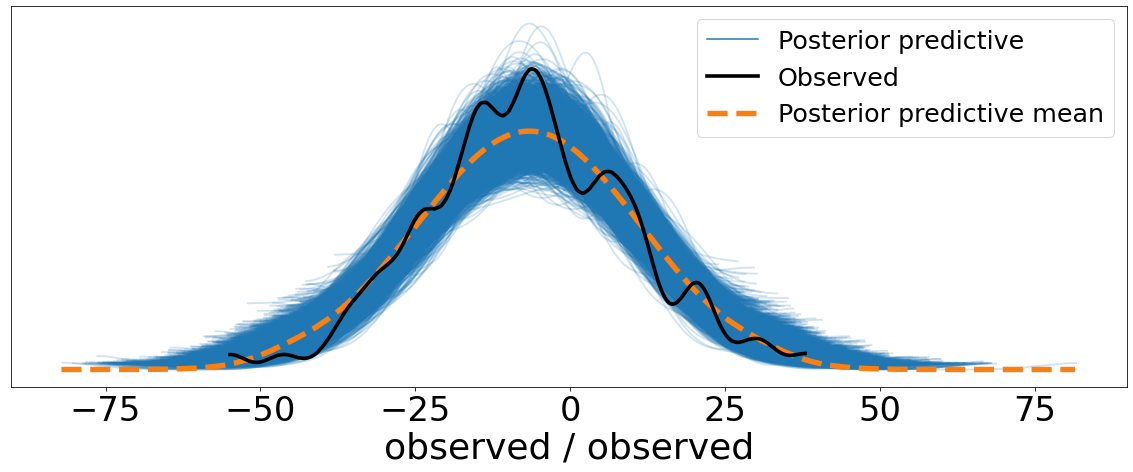

In [45]:
az.plot_ppc(ppc, figsize=(20, 7))

(array([36., 56., 32., 35., 23., 20., 14.,  8.,  3.,  0.,  2.,  1.]),
 array([ 0.        ,  4.58333333,  9.16666667, 13.75      , 18.33333333,
        22.91666667, 27.5       , 32.08333333, 36.66666667, 41.25      ,
        45.83333333, 50.41666667, 55.        ]),
 <BarContainer object of 12 artists>)

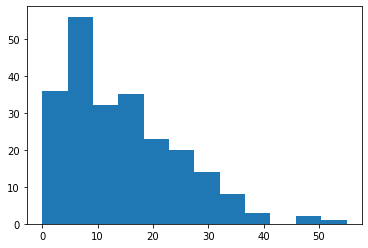

In [46]:
import matplotlib.pyplot as plt

plt.hist(np.abs(m['data']['score_diffs']), bins="auto")